In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#d9d9d9", # grey
    ]

PROPOSED_MFE_SUFFIXES = [
            "psi_",
            "overlap_",
            "omv_pth",
            "dc_accuracy",
            "dc_drift_flag",
            "_ks_statistic",
            "_ks_pvalue",
            "sqsi_drift_flag",
            "distance_class_",
            "u_detect_drift_flag",
            "predict",
            "last",
        ]

FINAL_FEATURE_FRACTION = {'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

In [3]:

TYPE_DICT = {"with_drift": "proposed_mtl", "without_drift": "original_mtl"}

def get_bar_color(row):
    if any(suffix in row["feature"] for suffix in PROPOSED_MFE_SUFFIXES):
        return COLORS[0]
    return COLORS[1]

def _load_data(base_model: str="RandomForestClassifier", dataset: str="electricity", feature_fraction: int=100):
    filename = f"results_importances/base_model: {base_model} - dataset: {dataset} - select_k_features: {feature_fraction}%.json"
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

def _get_mean_importances(data: dict):
    final_df = pd.DataFrame(columns=["feature", "importance", "type", "meta_label"])
    for metric, value in data.items():
        for drift_flag in value.keys():
            importances_df = pd.DataFrame()
            importances_df["importance"] = pd.DataFrame(data[metric][drift_flag]).mean()
            importances_df["type"] = TYPE_DICT[drift_flag]
            importances_df["meta_label"] = metric
            importances_df = importances_df.reset_index().rename(columns={"index": "feature"})
            final_df = pd.concat([final_df, importances_df])
    return final_df

def _plot_results(data: dict, final_df: pd.DataFrame, n_feat_to_plot: int=20, figsize=(25, 35), suptitle=""):
    metrics = list(data.keys())
    drift_flags = list(data['kappa'].keys())
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=25)
    final_df["color"] = final_df.apply(get_bar_color, axis=1)

    for metric_idx, metric in enumerate(metrics):
        for drift_idx, drift_flag in enumerate(drift_flags):
            plt.subplot(len(metrics), len(drift_flags), metric_idx * 2 + drift_idx + 1)
            plt.title(f"{metric} - {TYPE_DICT[drift_flag]}")
            plot_df = final_df[(final_df["type"] == TYPE_DICT[drift_flag]) & (final_df["meta_label"] == metric)]
            plot_df = plot_df.sort_values(by=["importance"]).tail(n_feat_to_plot)
            plt.barh(plot_df["feature"], plot_df["importance"], color=plot_df["color"])
            plt.tight_layout()
    plt.subplots_adjust(top=0.95)

def run(base_model: str="RandomForestClassifier", dataset: str="electricity", n_feat_to_plot: int=20, figsize: tuple=(25, 35), feature_fraction: int=100):
    data = _load_data(base_model, dataset, feature_fraction)
    data.pop("auc", None)
    imp_df = _get_mean_importances(data)
    _plot_results(
        data=data,
        final_df=imp_df,
        n_feat_to_plot=n_feat_to_plot,
        figsize=figsize,
        suptitle=f"base_model: {base_model} - dataset: {dataset}")

# Base models

## Decision tree

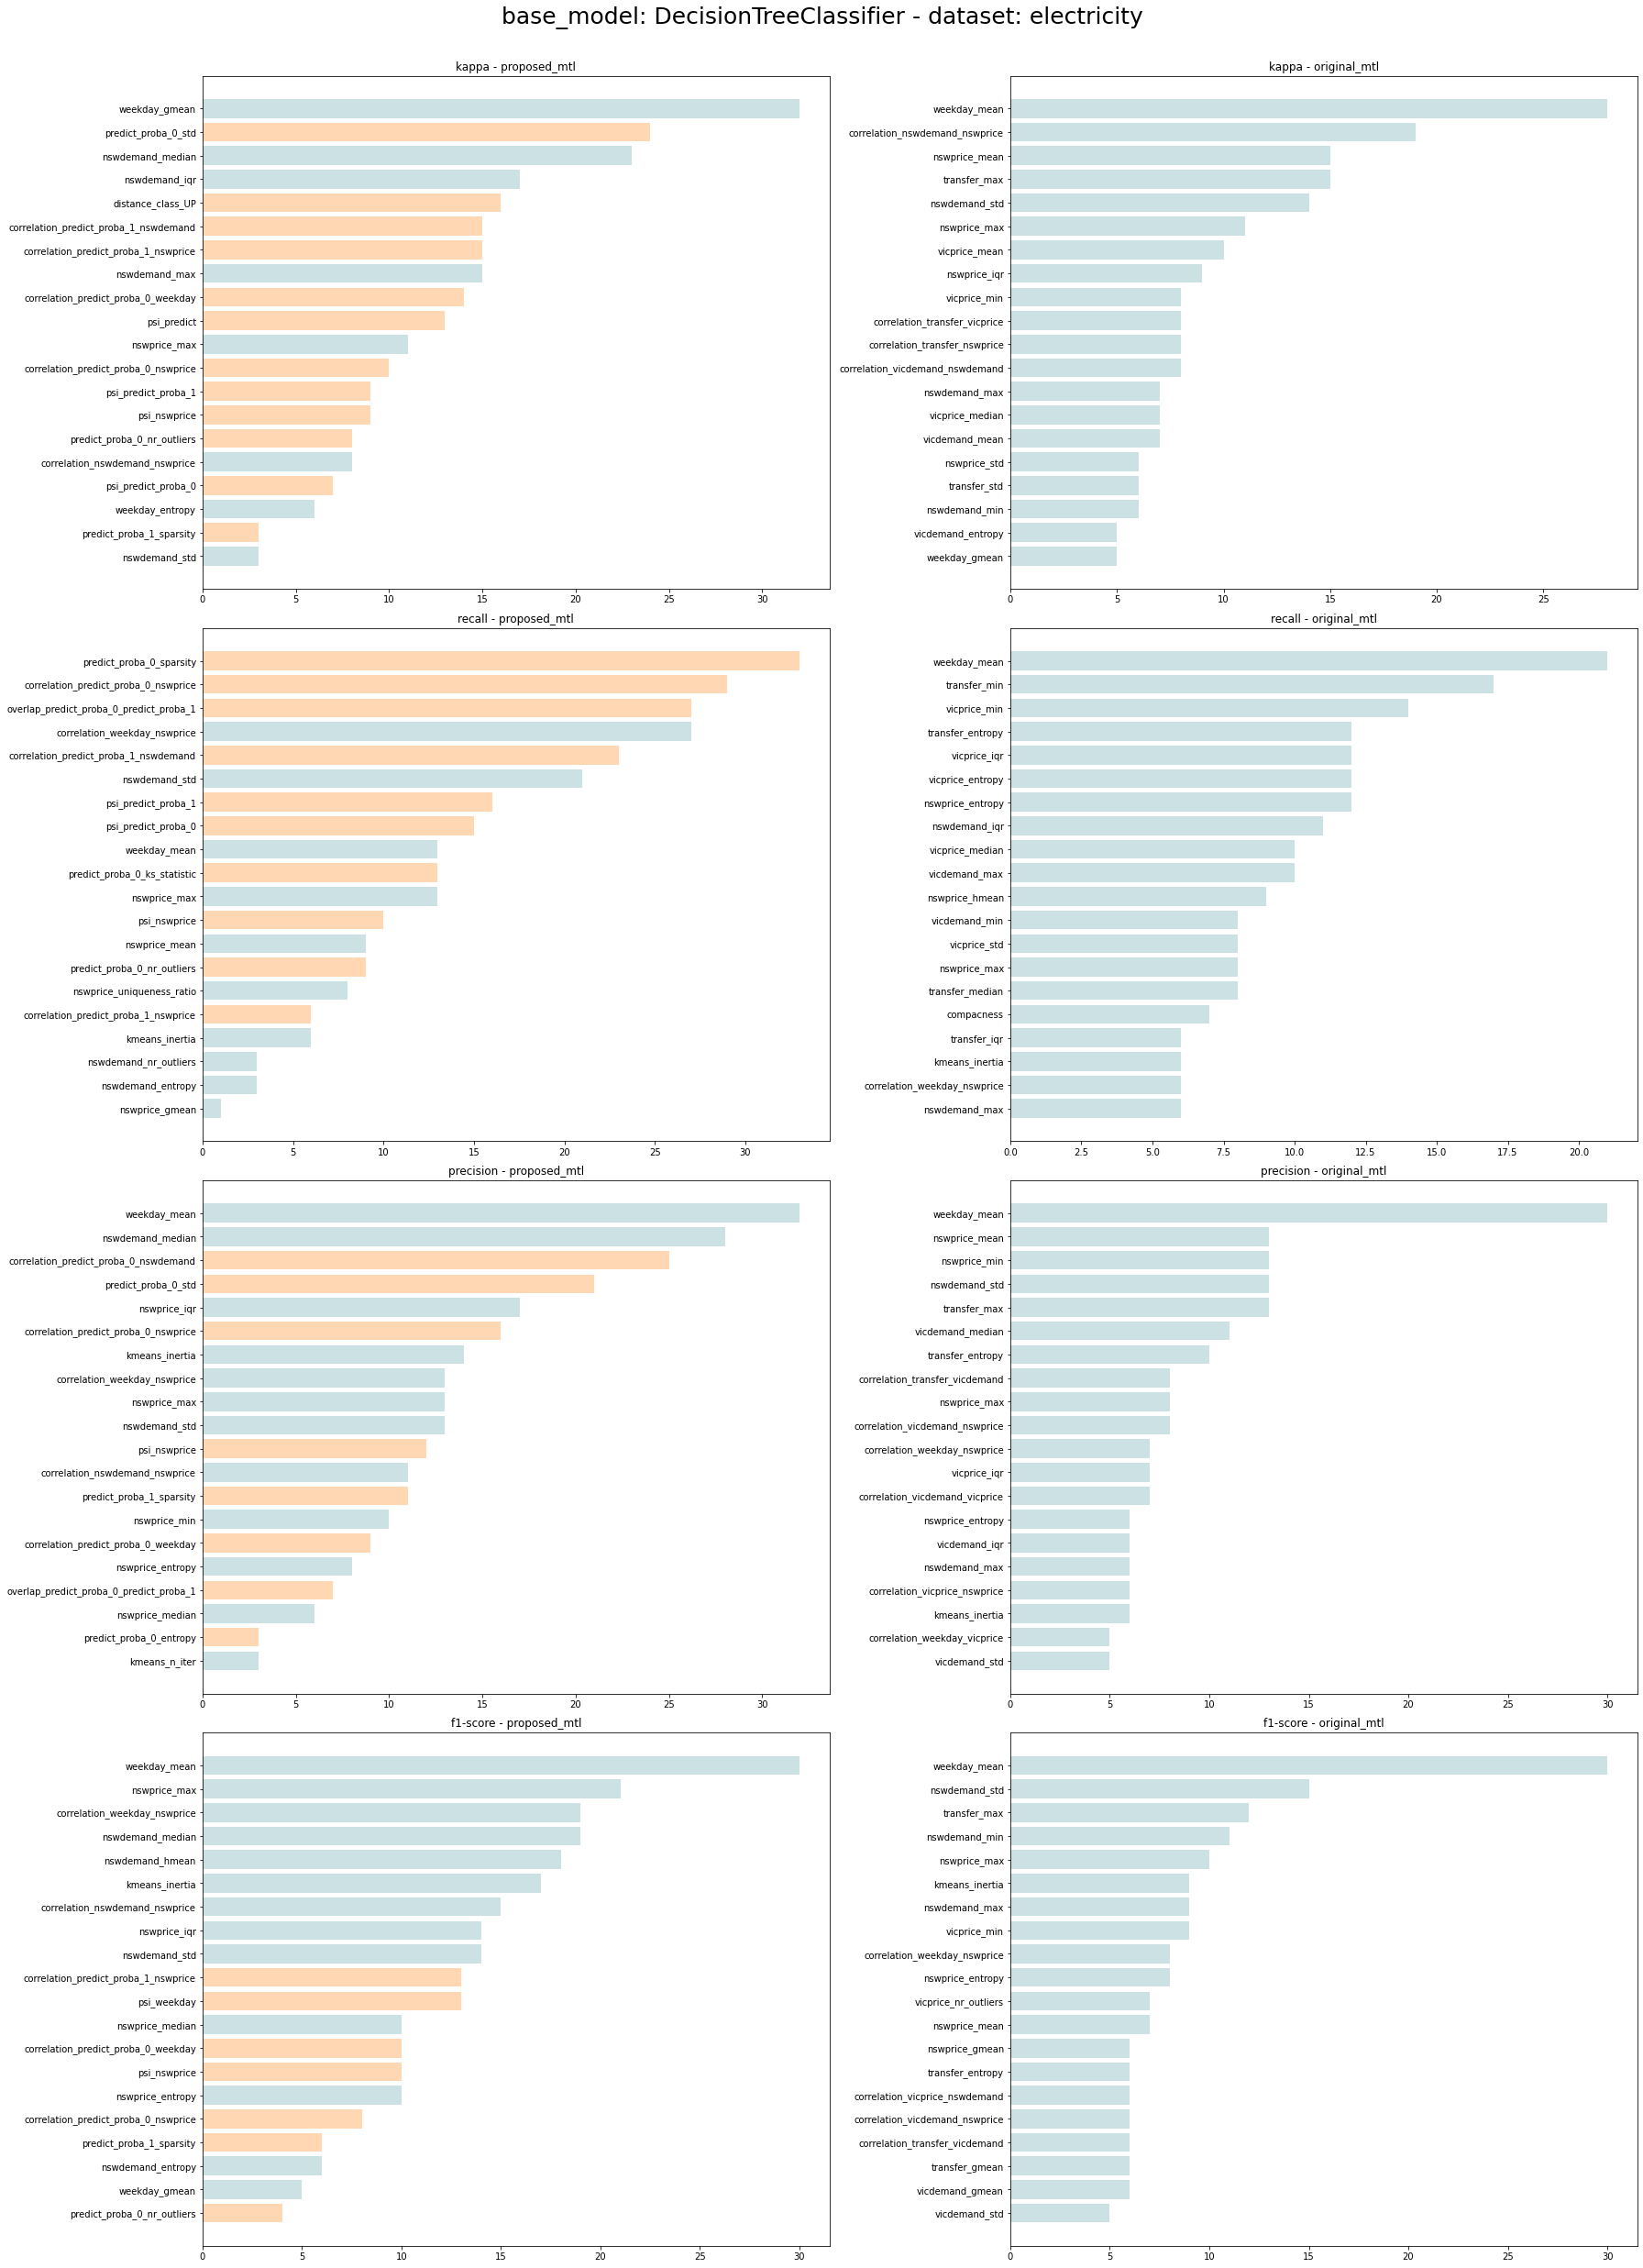

In [4]:
run(base_model="DecisionTreeClassifier", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

## SVM

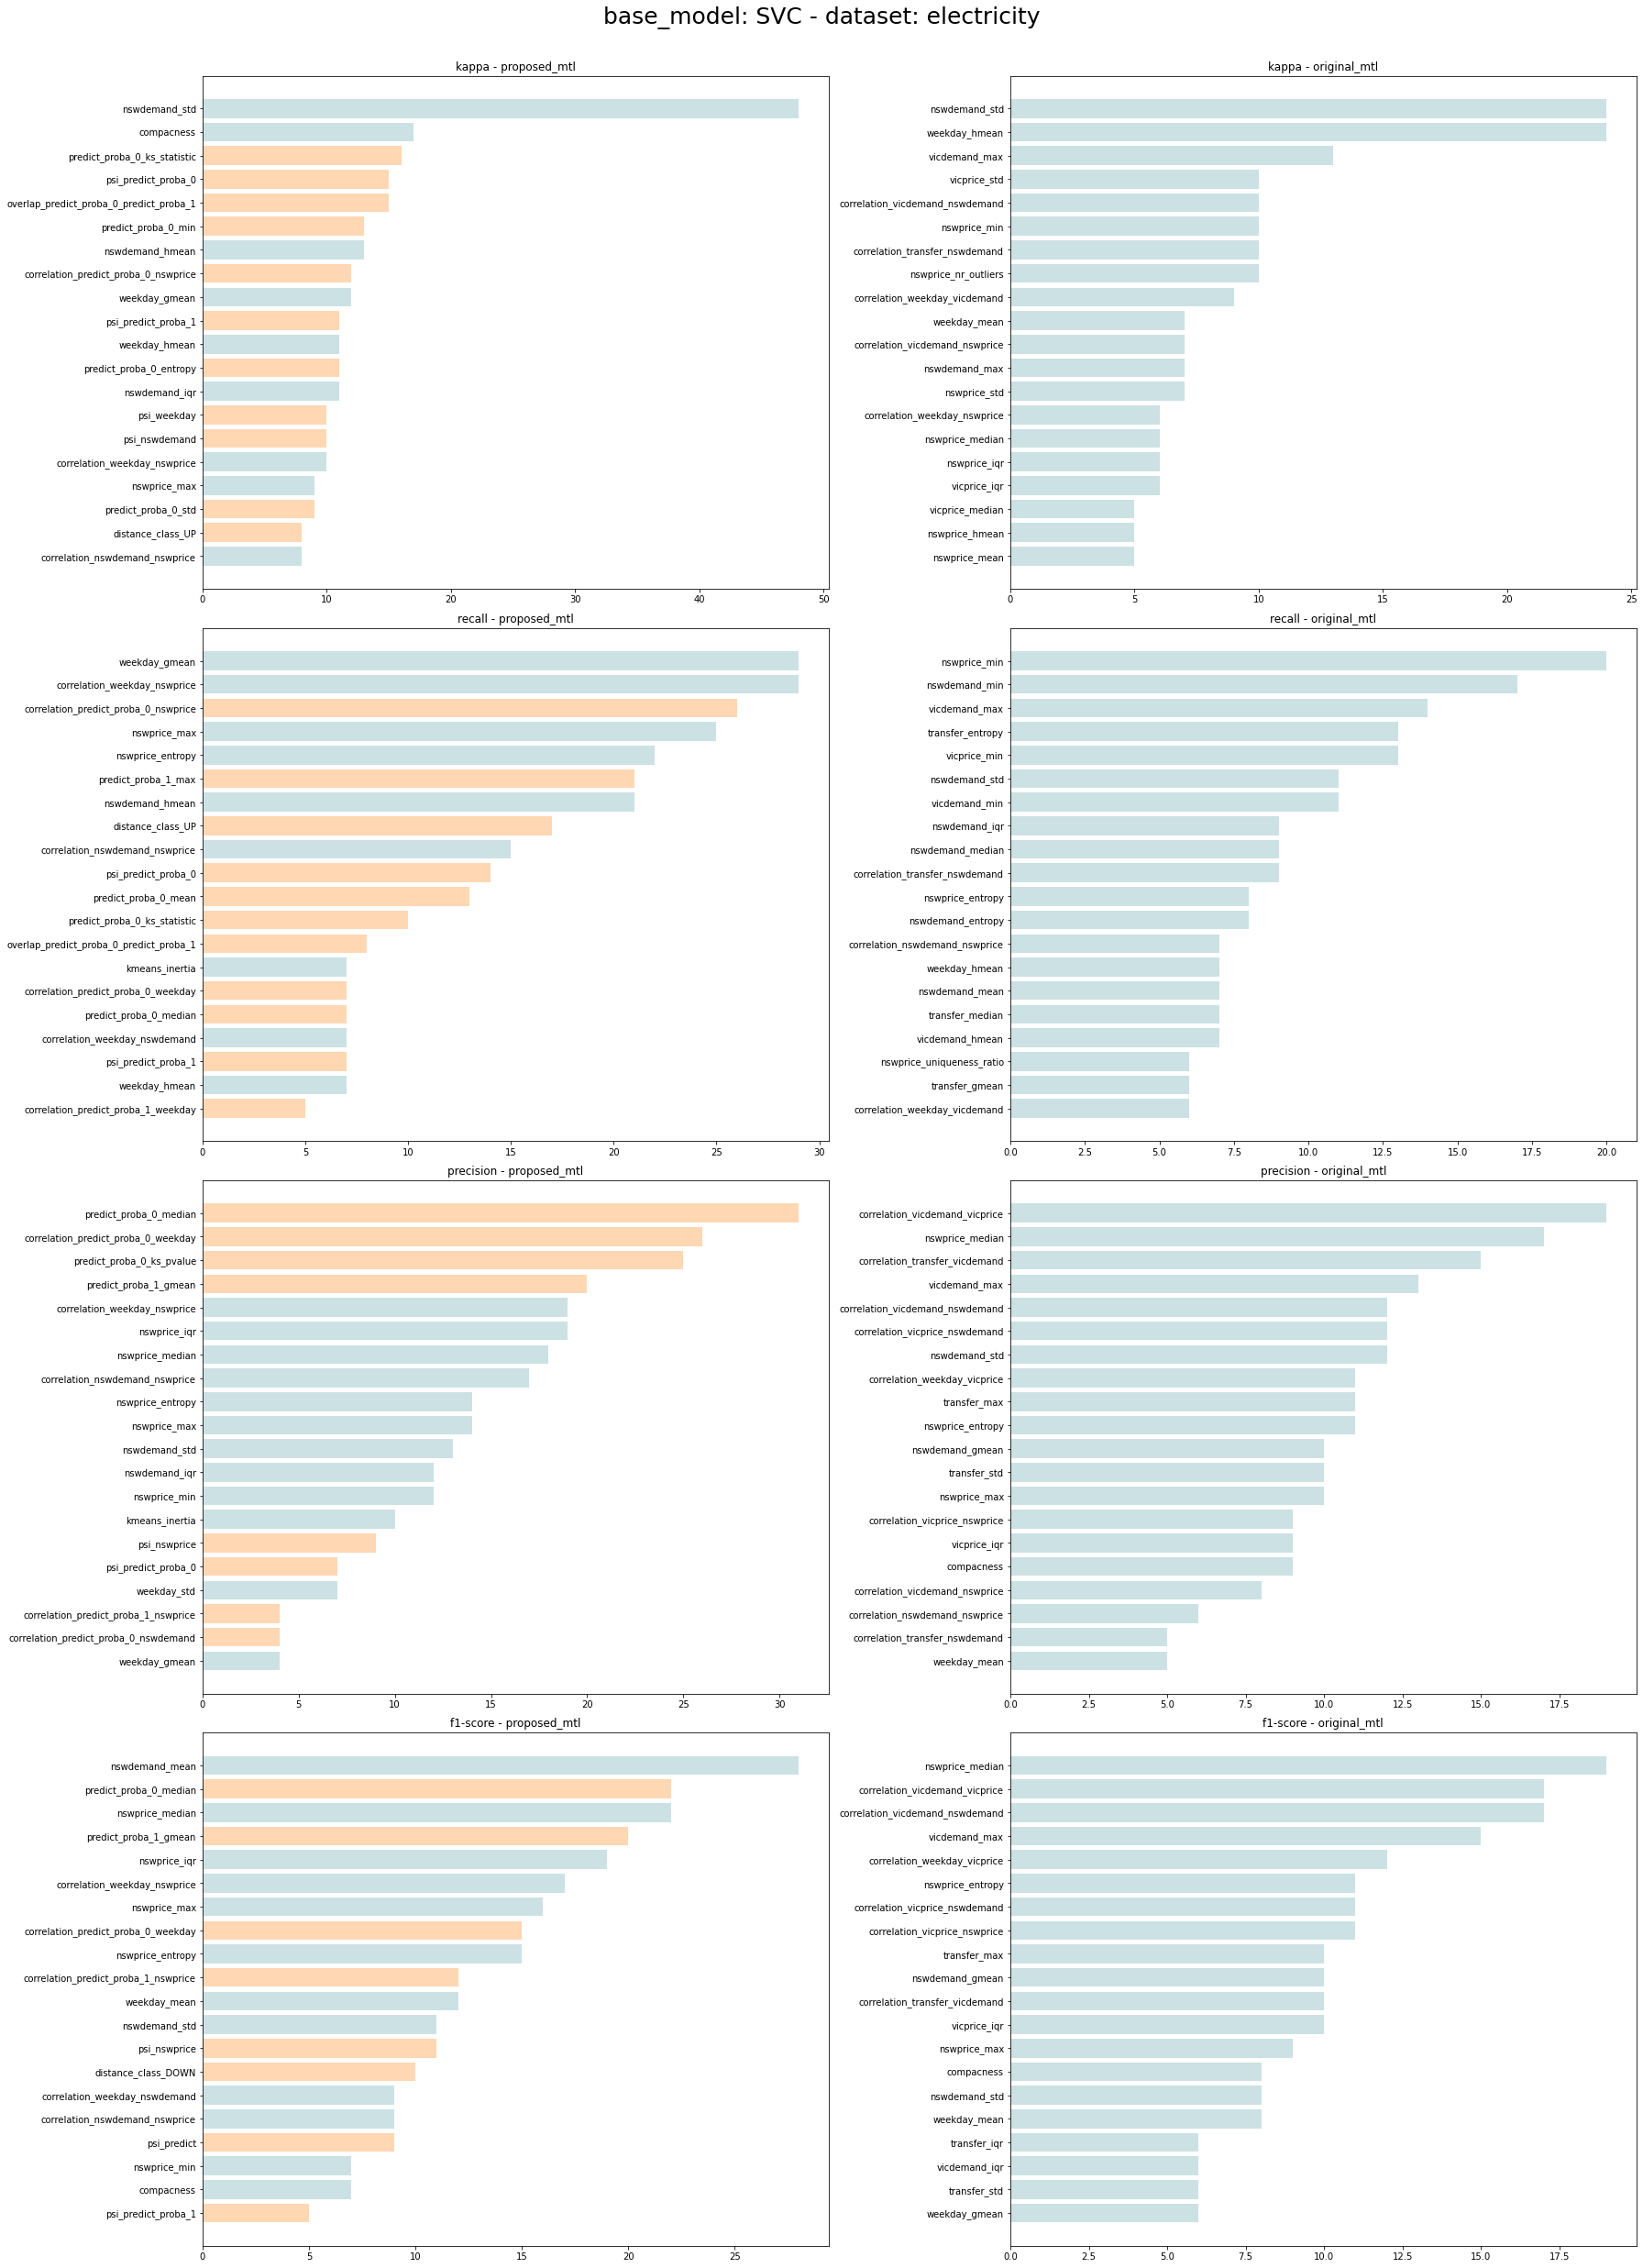

In [5]:
run(base_model="SVC", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

## LogisticRegression

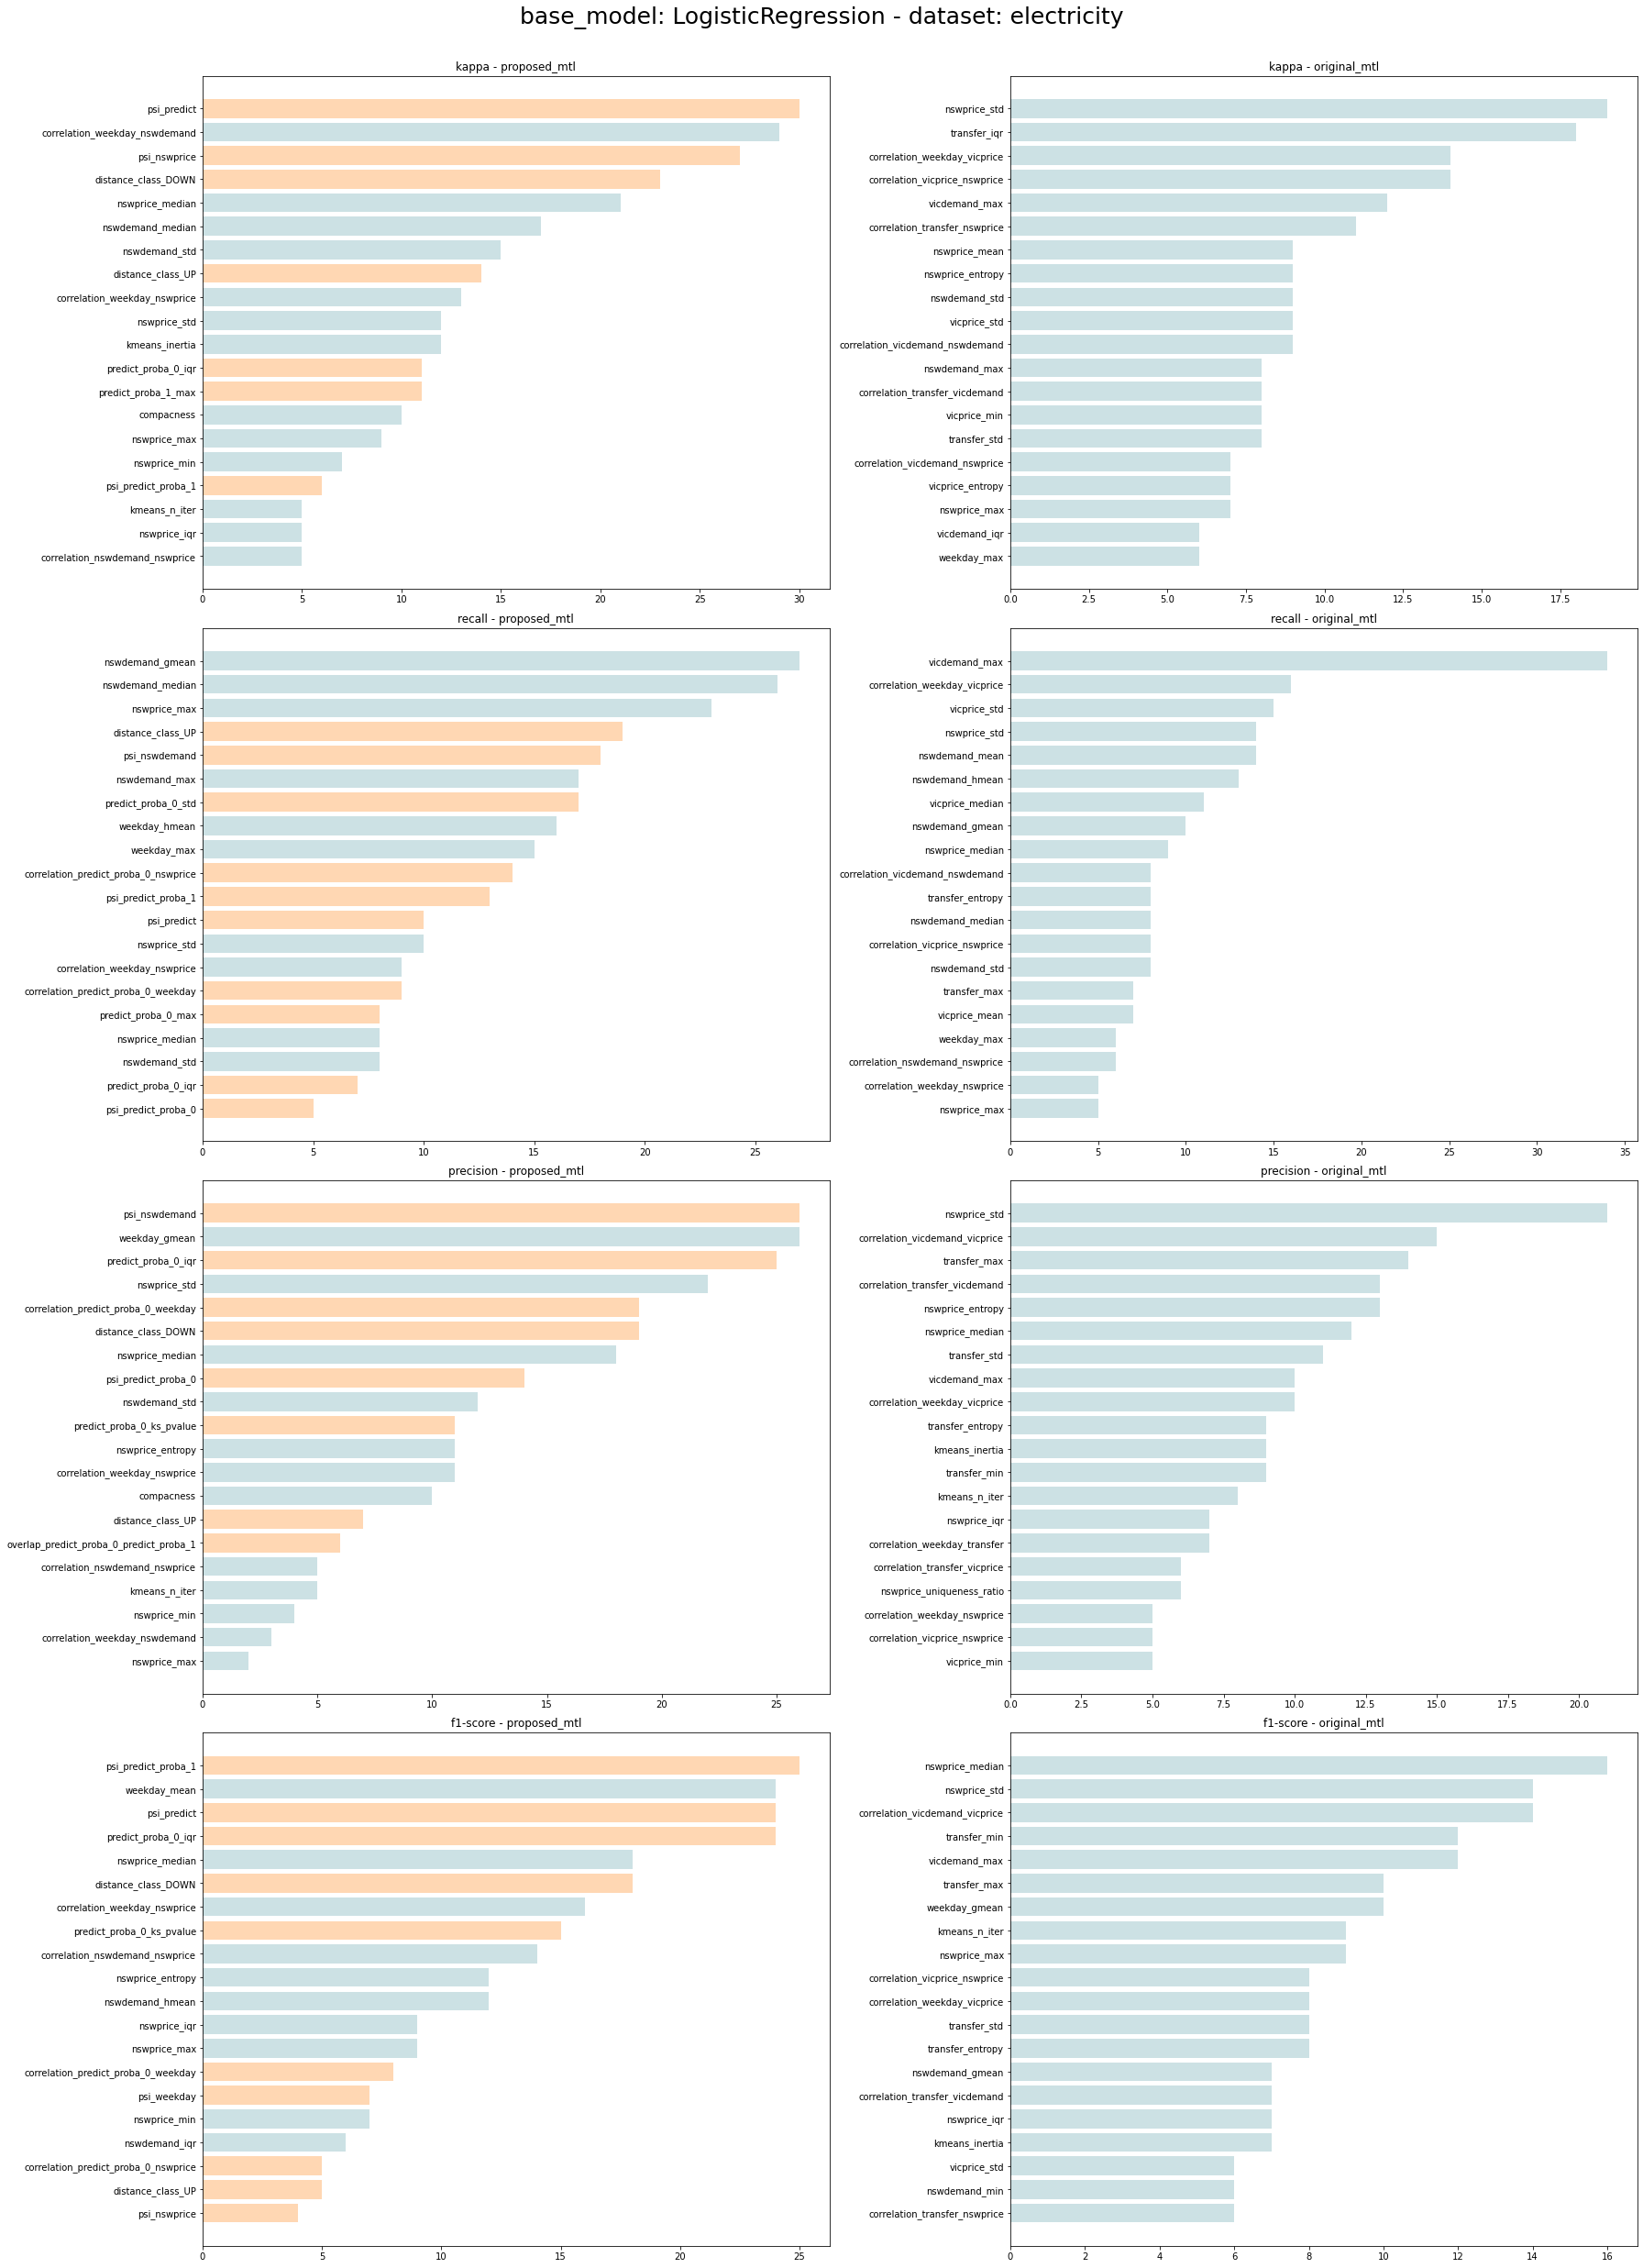

In [6]:
run(base_model="LogisticRegression", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

# Datasets

# Electricity

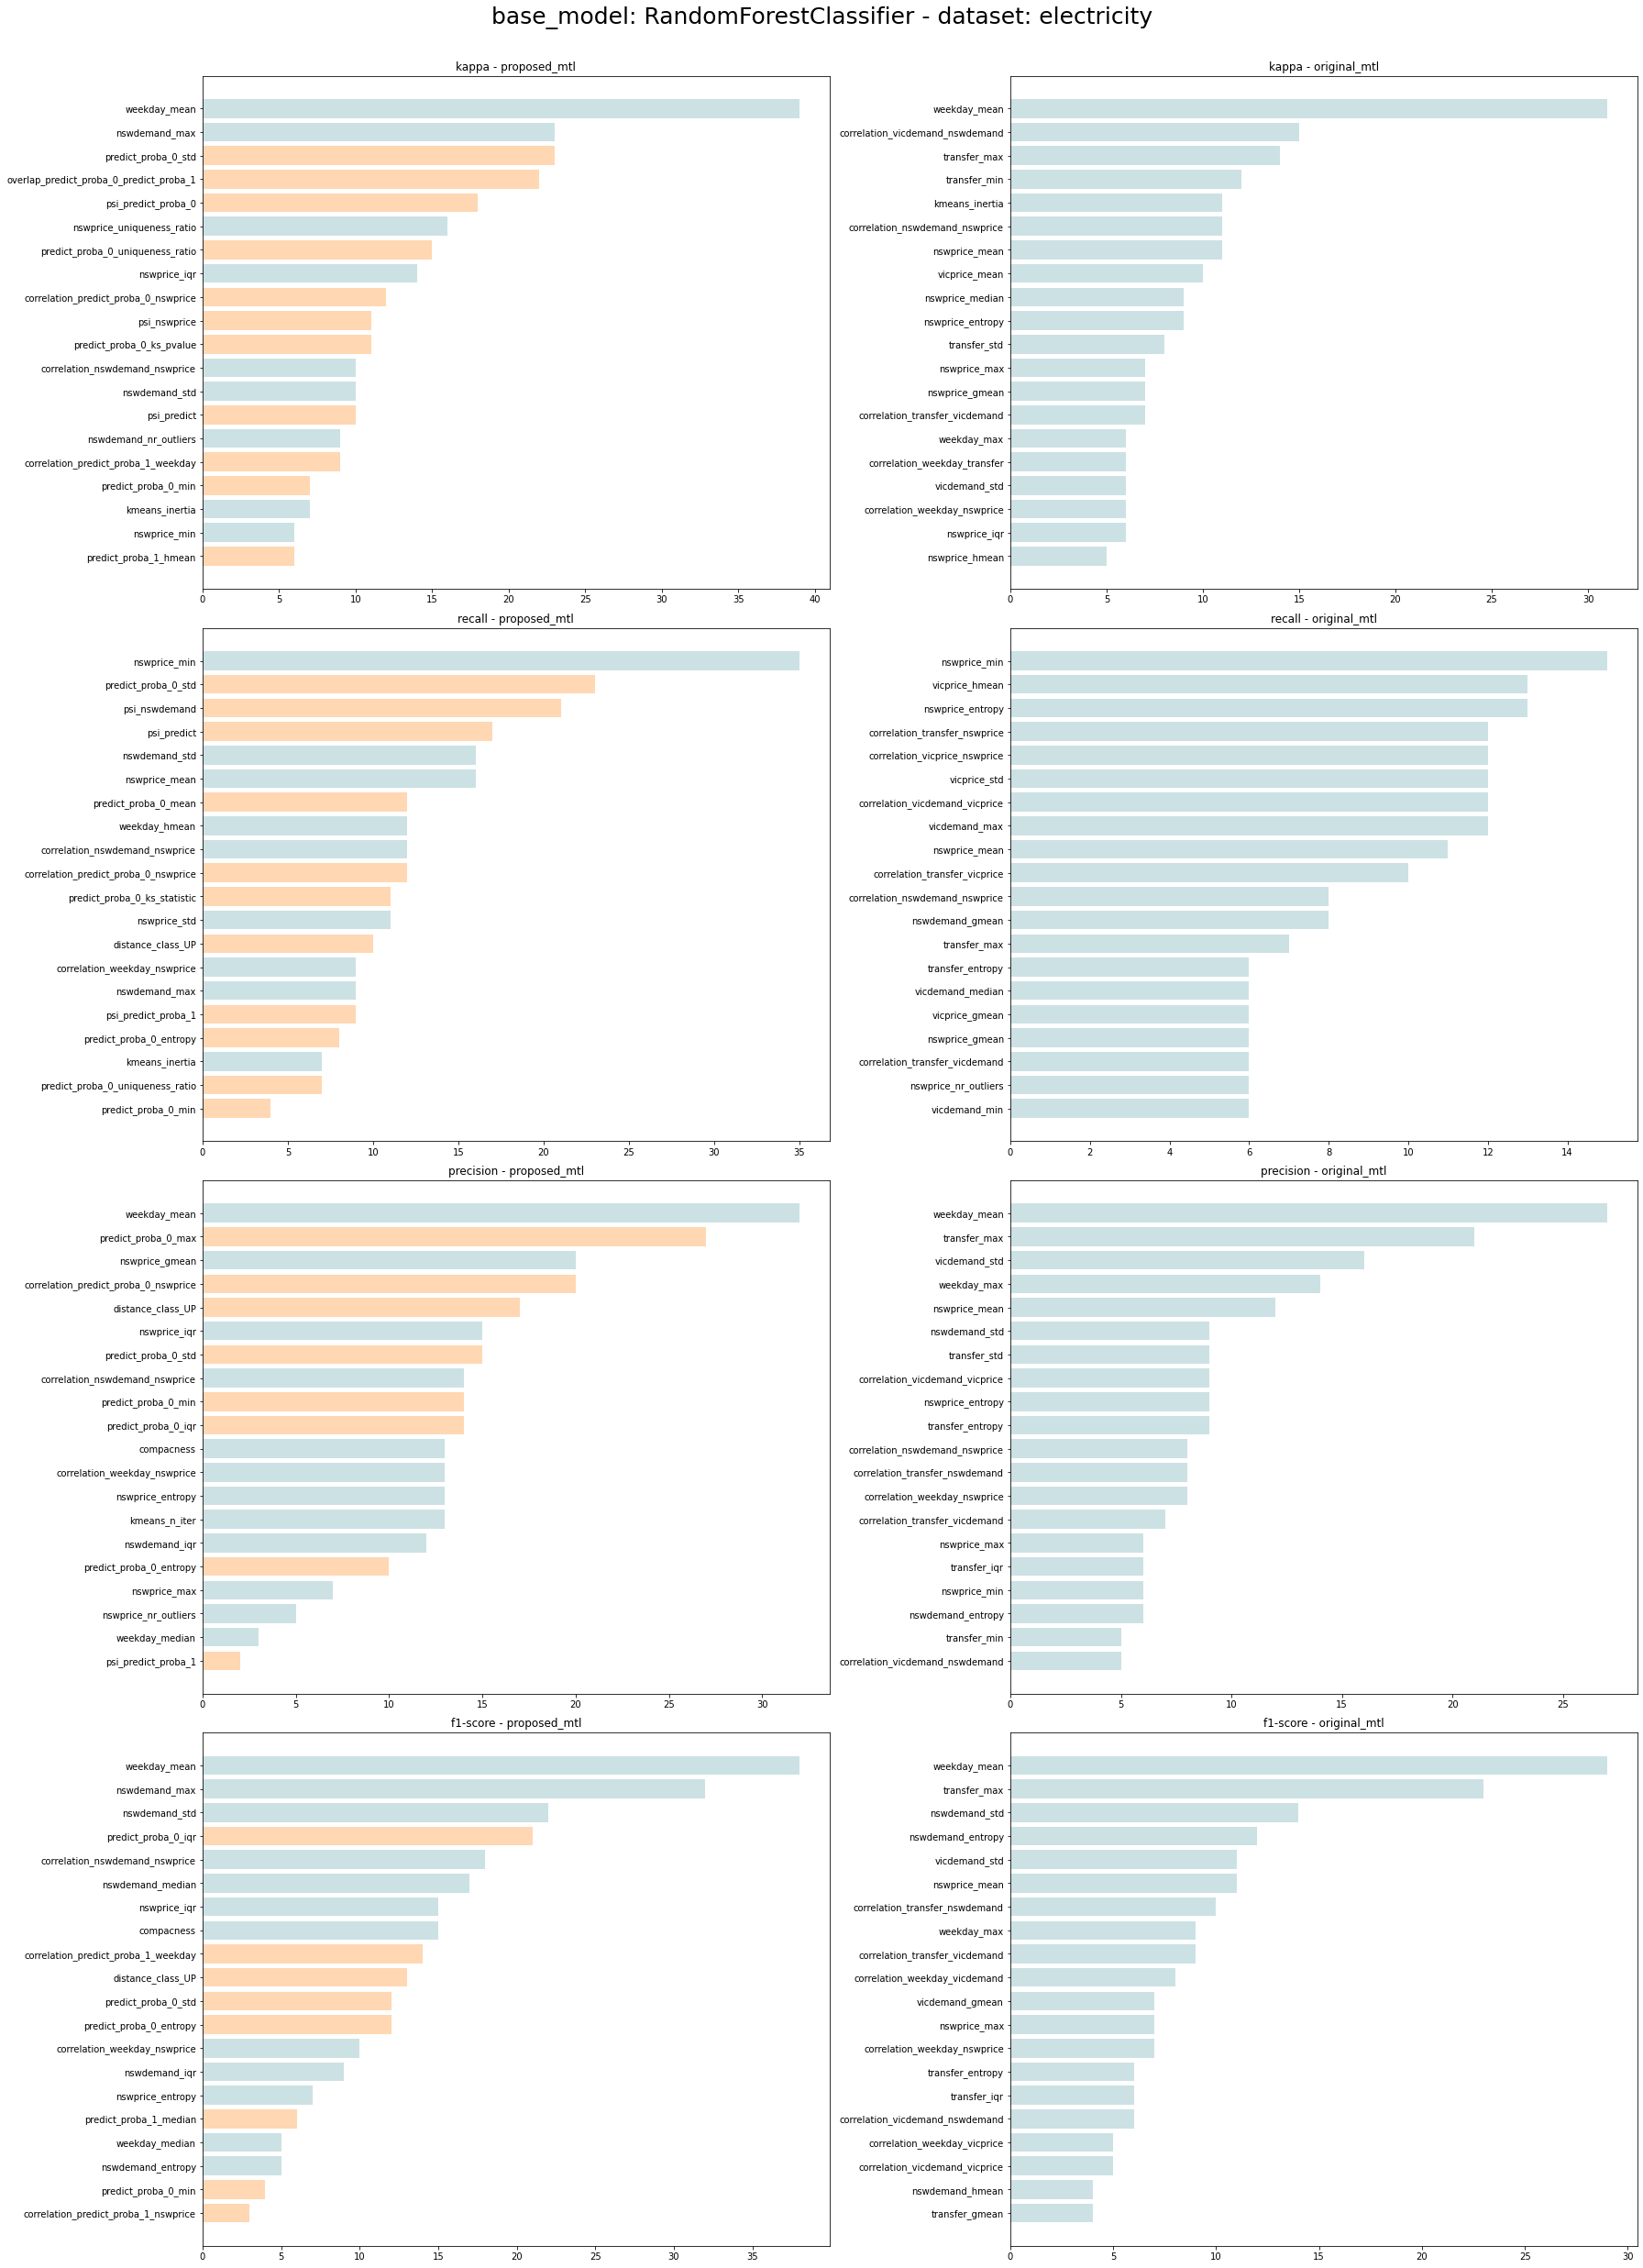

In [7]:
run(base_model="RandomForestClassifier", dataset="electricity", feature_fraction=FINAL_FEATURE_FRACTION["electricity"])

# Airlines

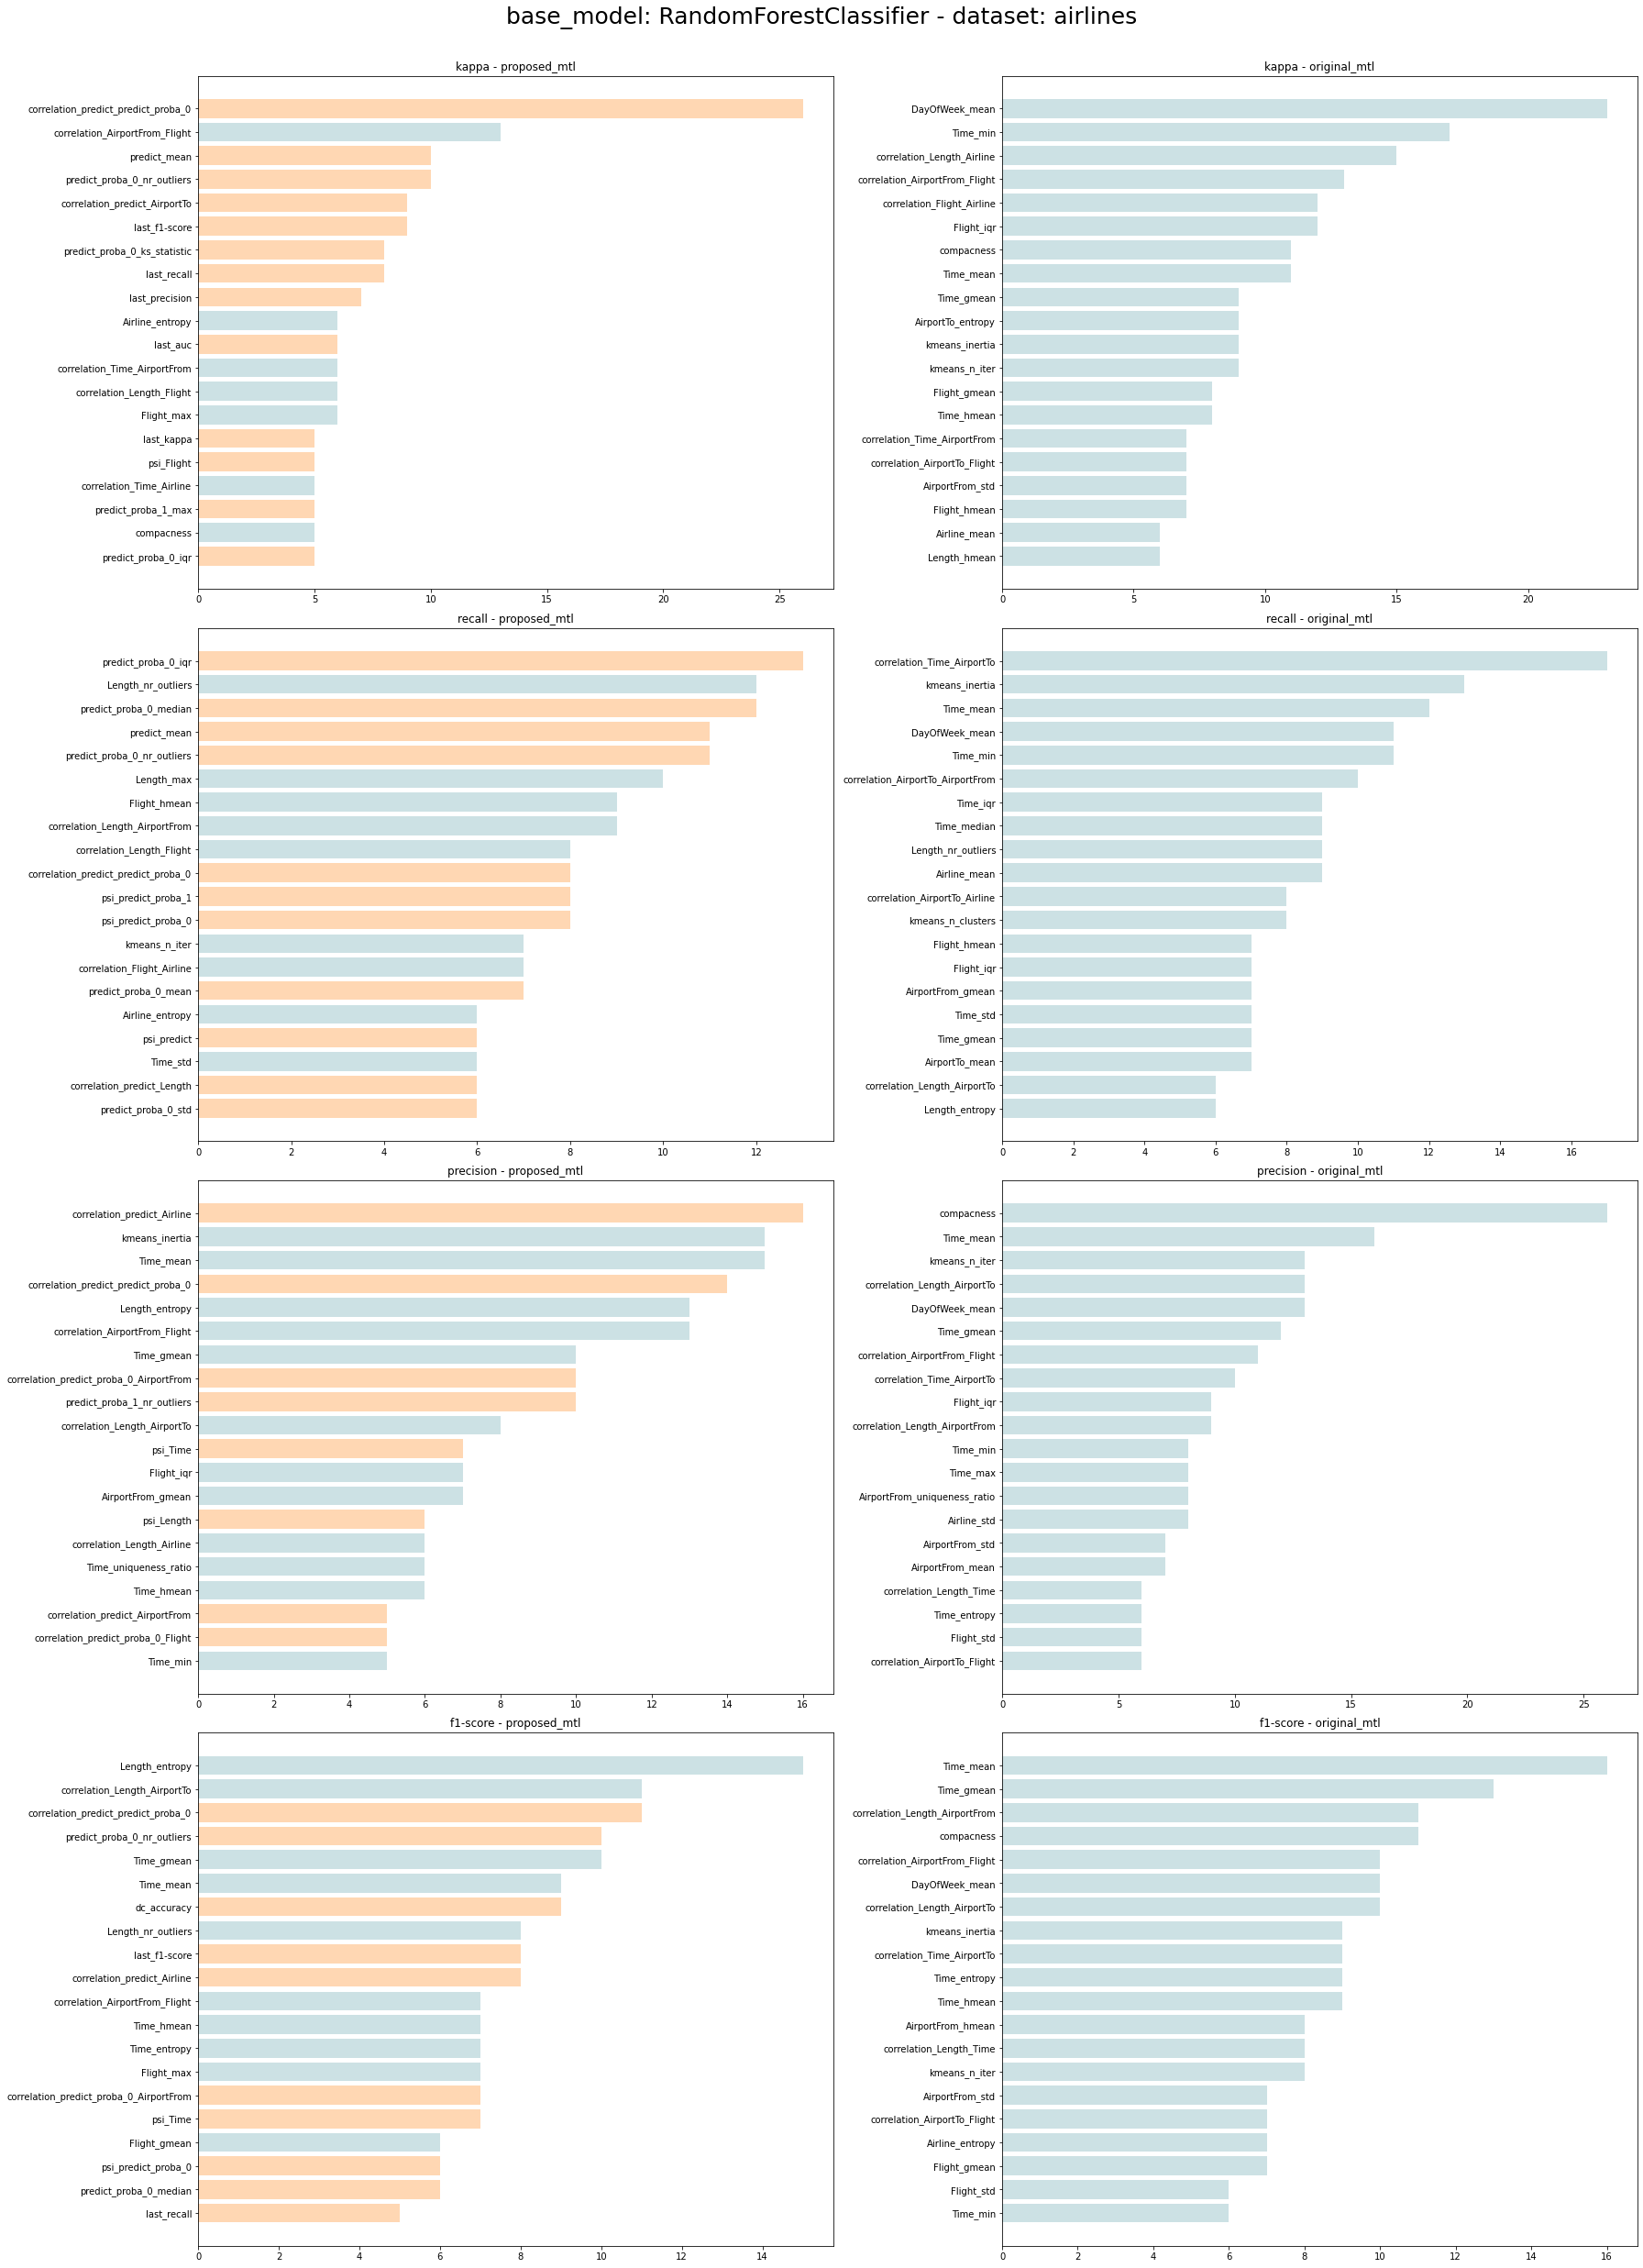

In [8]:
run(base_model="RandomForestClassifier", dataset="airlines", feature_fraction=FINAL_FEATURE_FRACTION["airlines"])

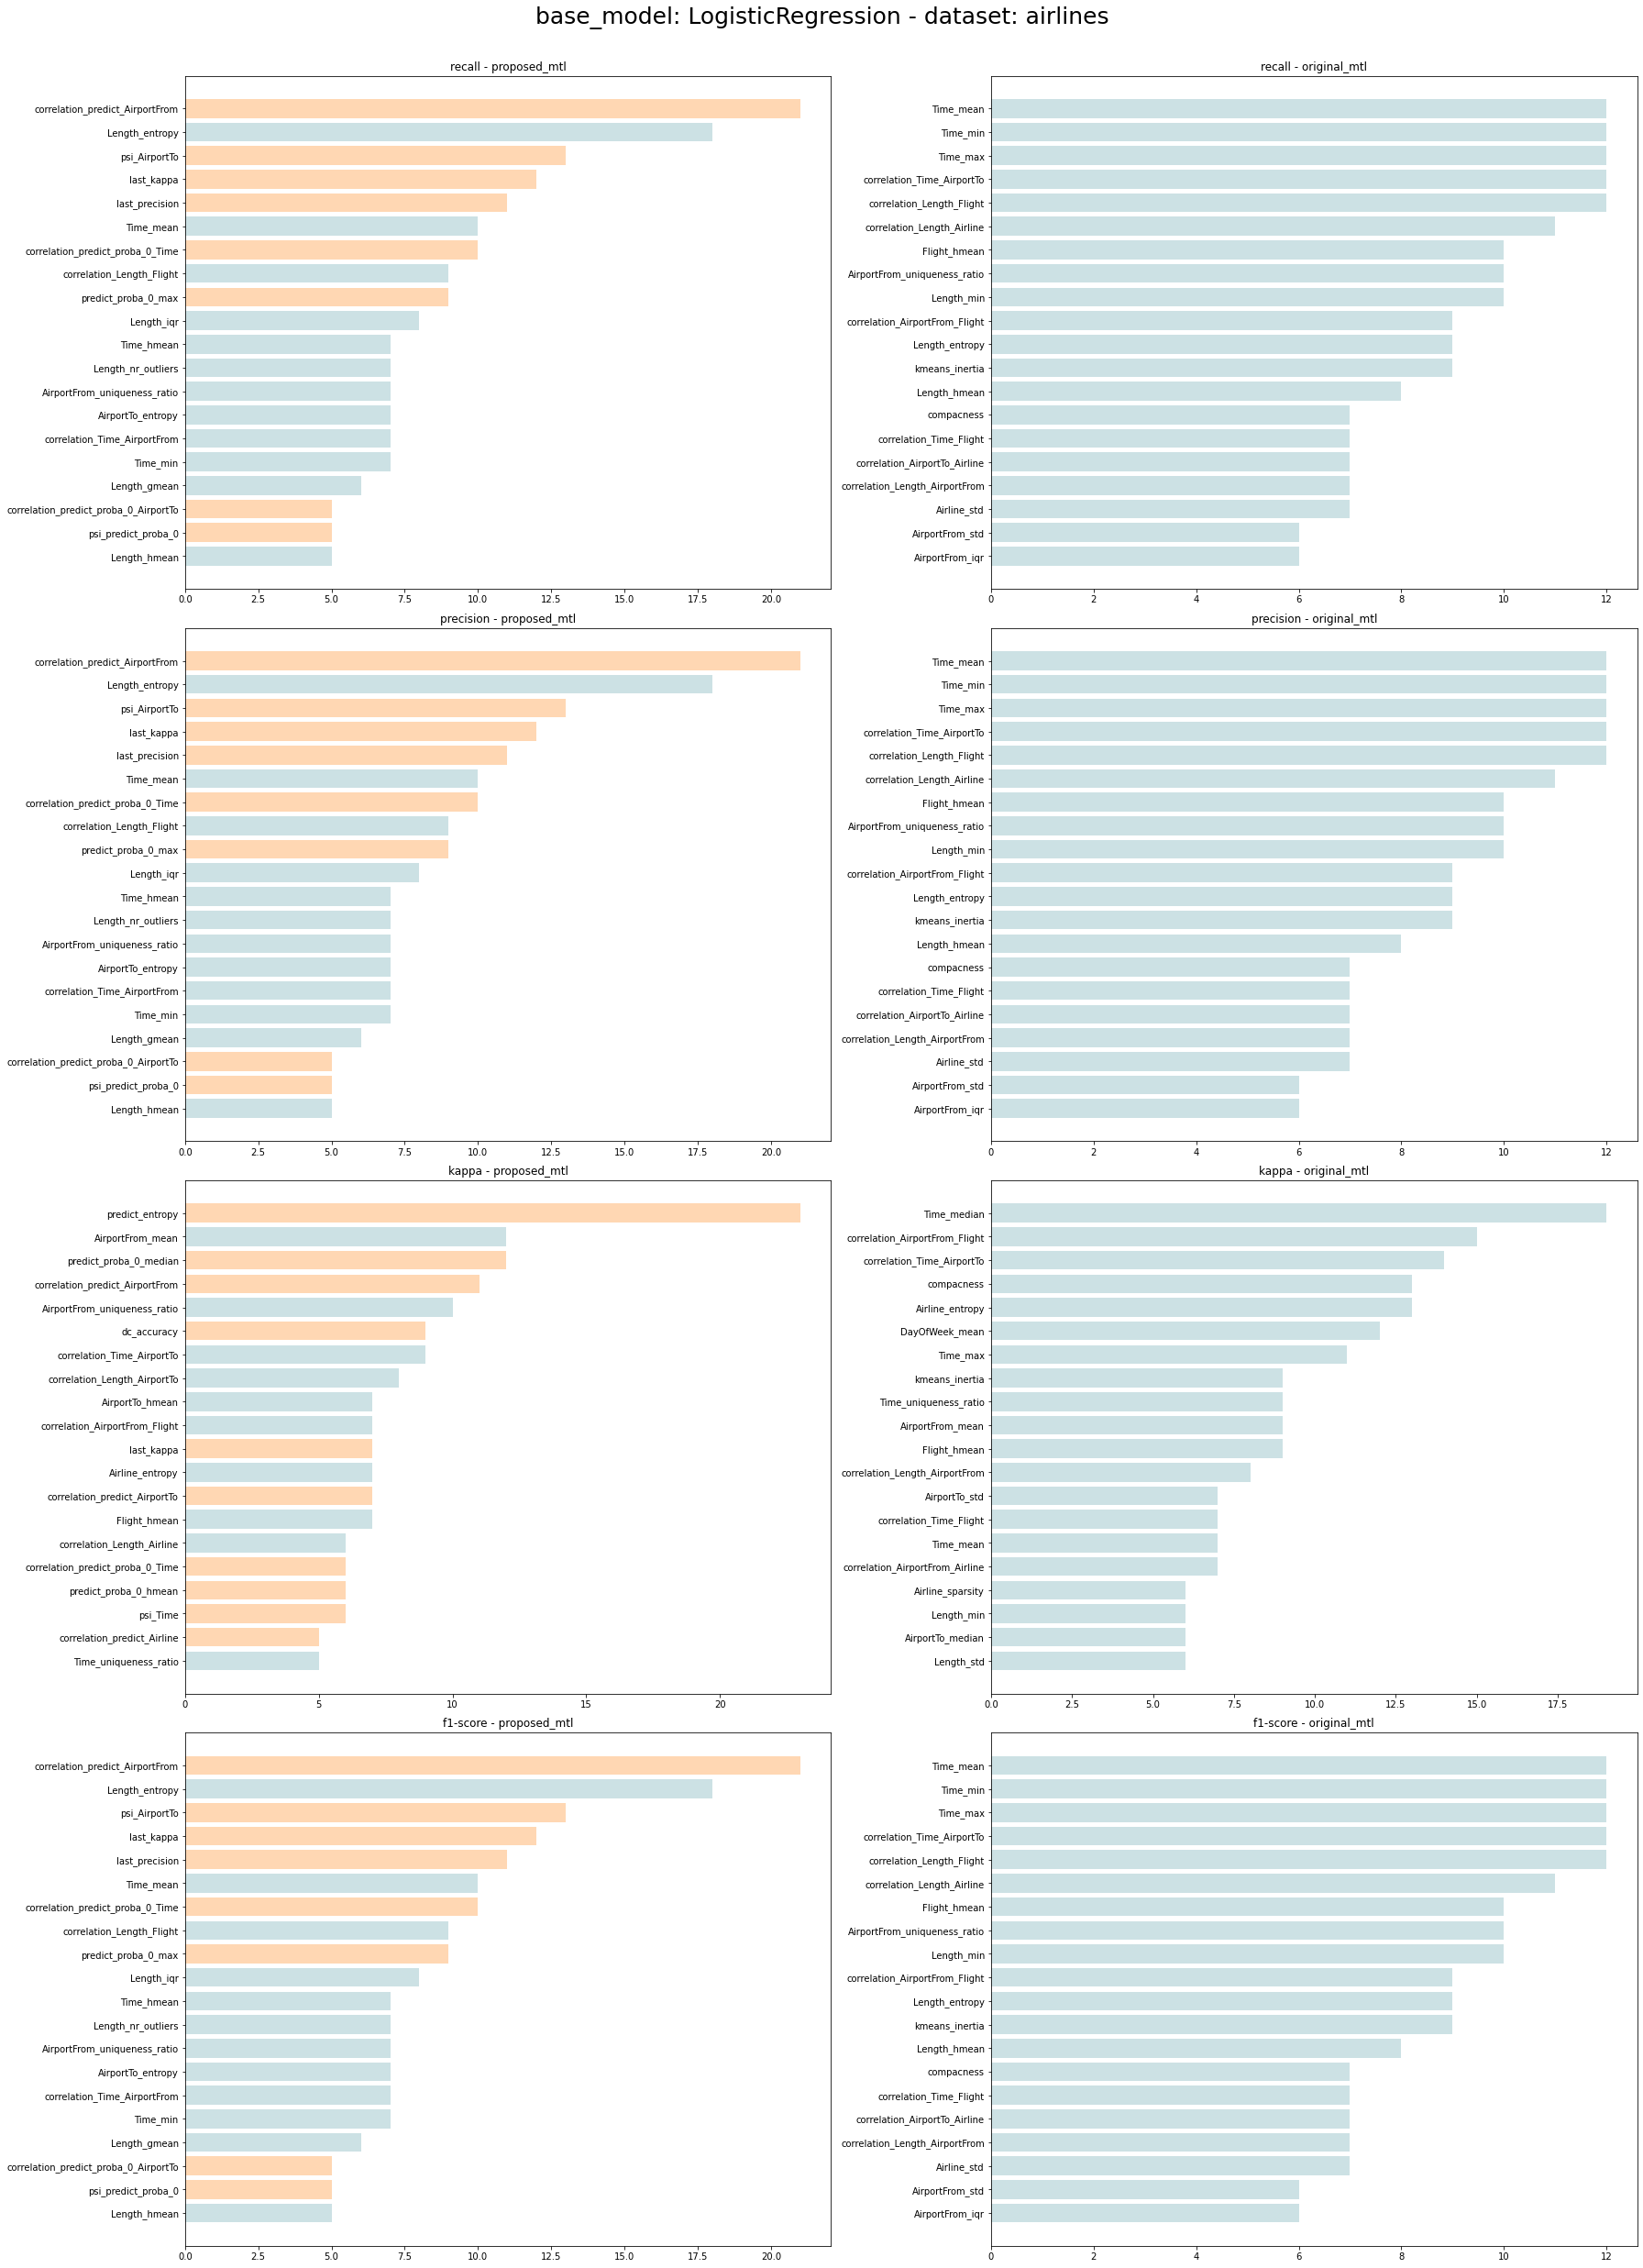

In [9]:
run(base_model="LogisticRegression", dataset="airlines", feature_fraction=FINAL_FEATURE_FRACTION["airlines"])

# powersupply

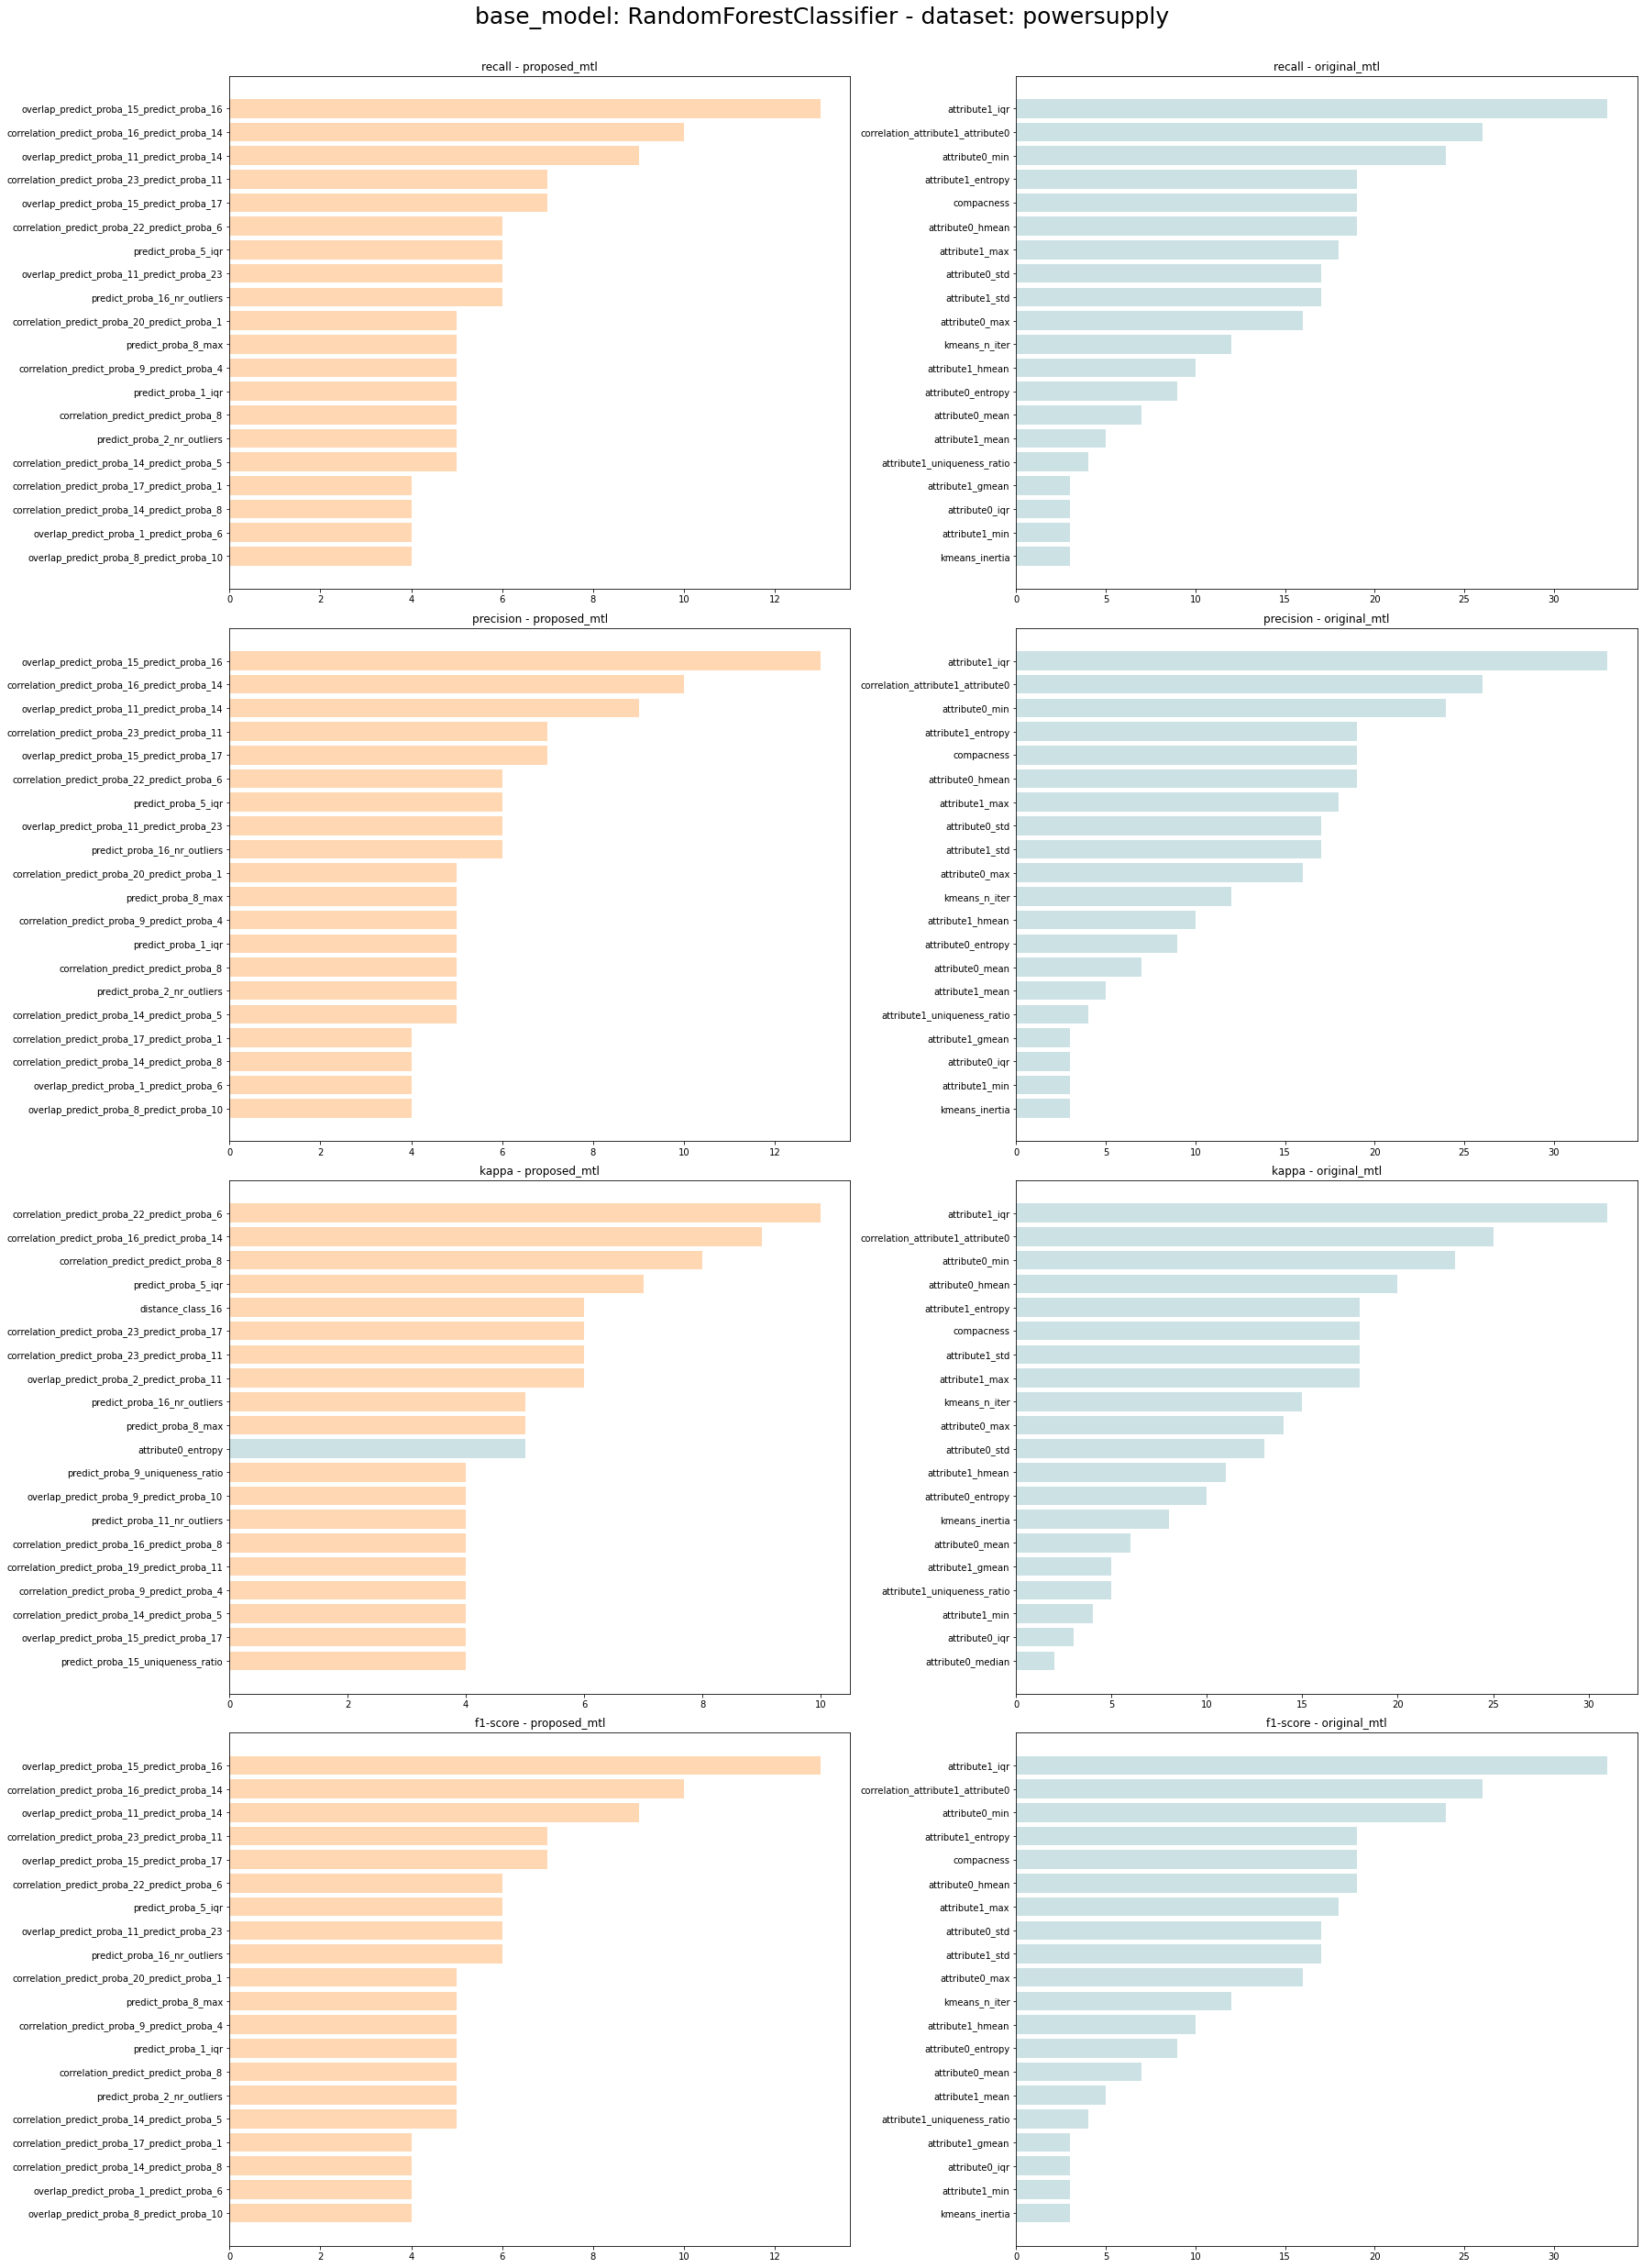

In [10]:
run(base_model="RandomForestClassifier", dataset="powersupply", feature_fraction=FINAL_FEATURE_FRACTION["powersupply"])

# rialto

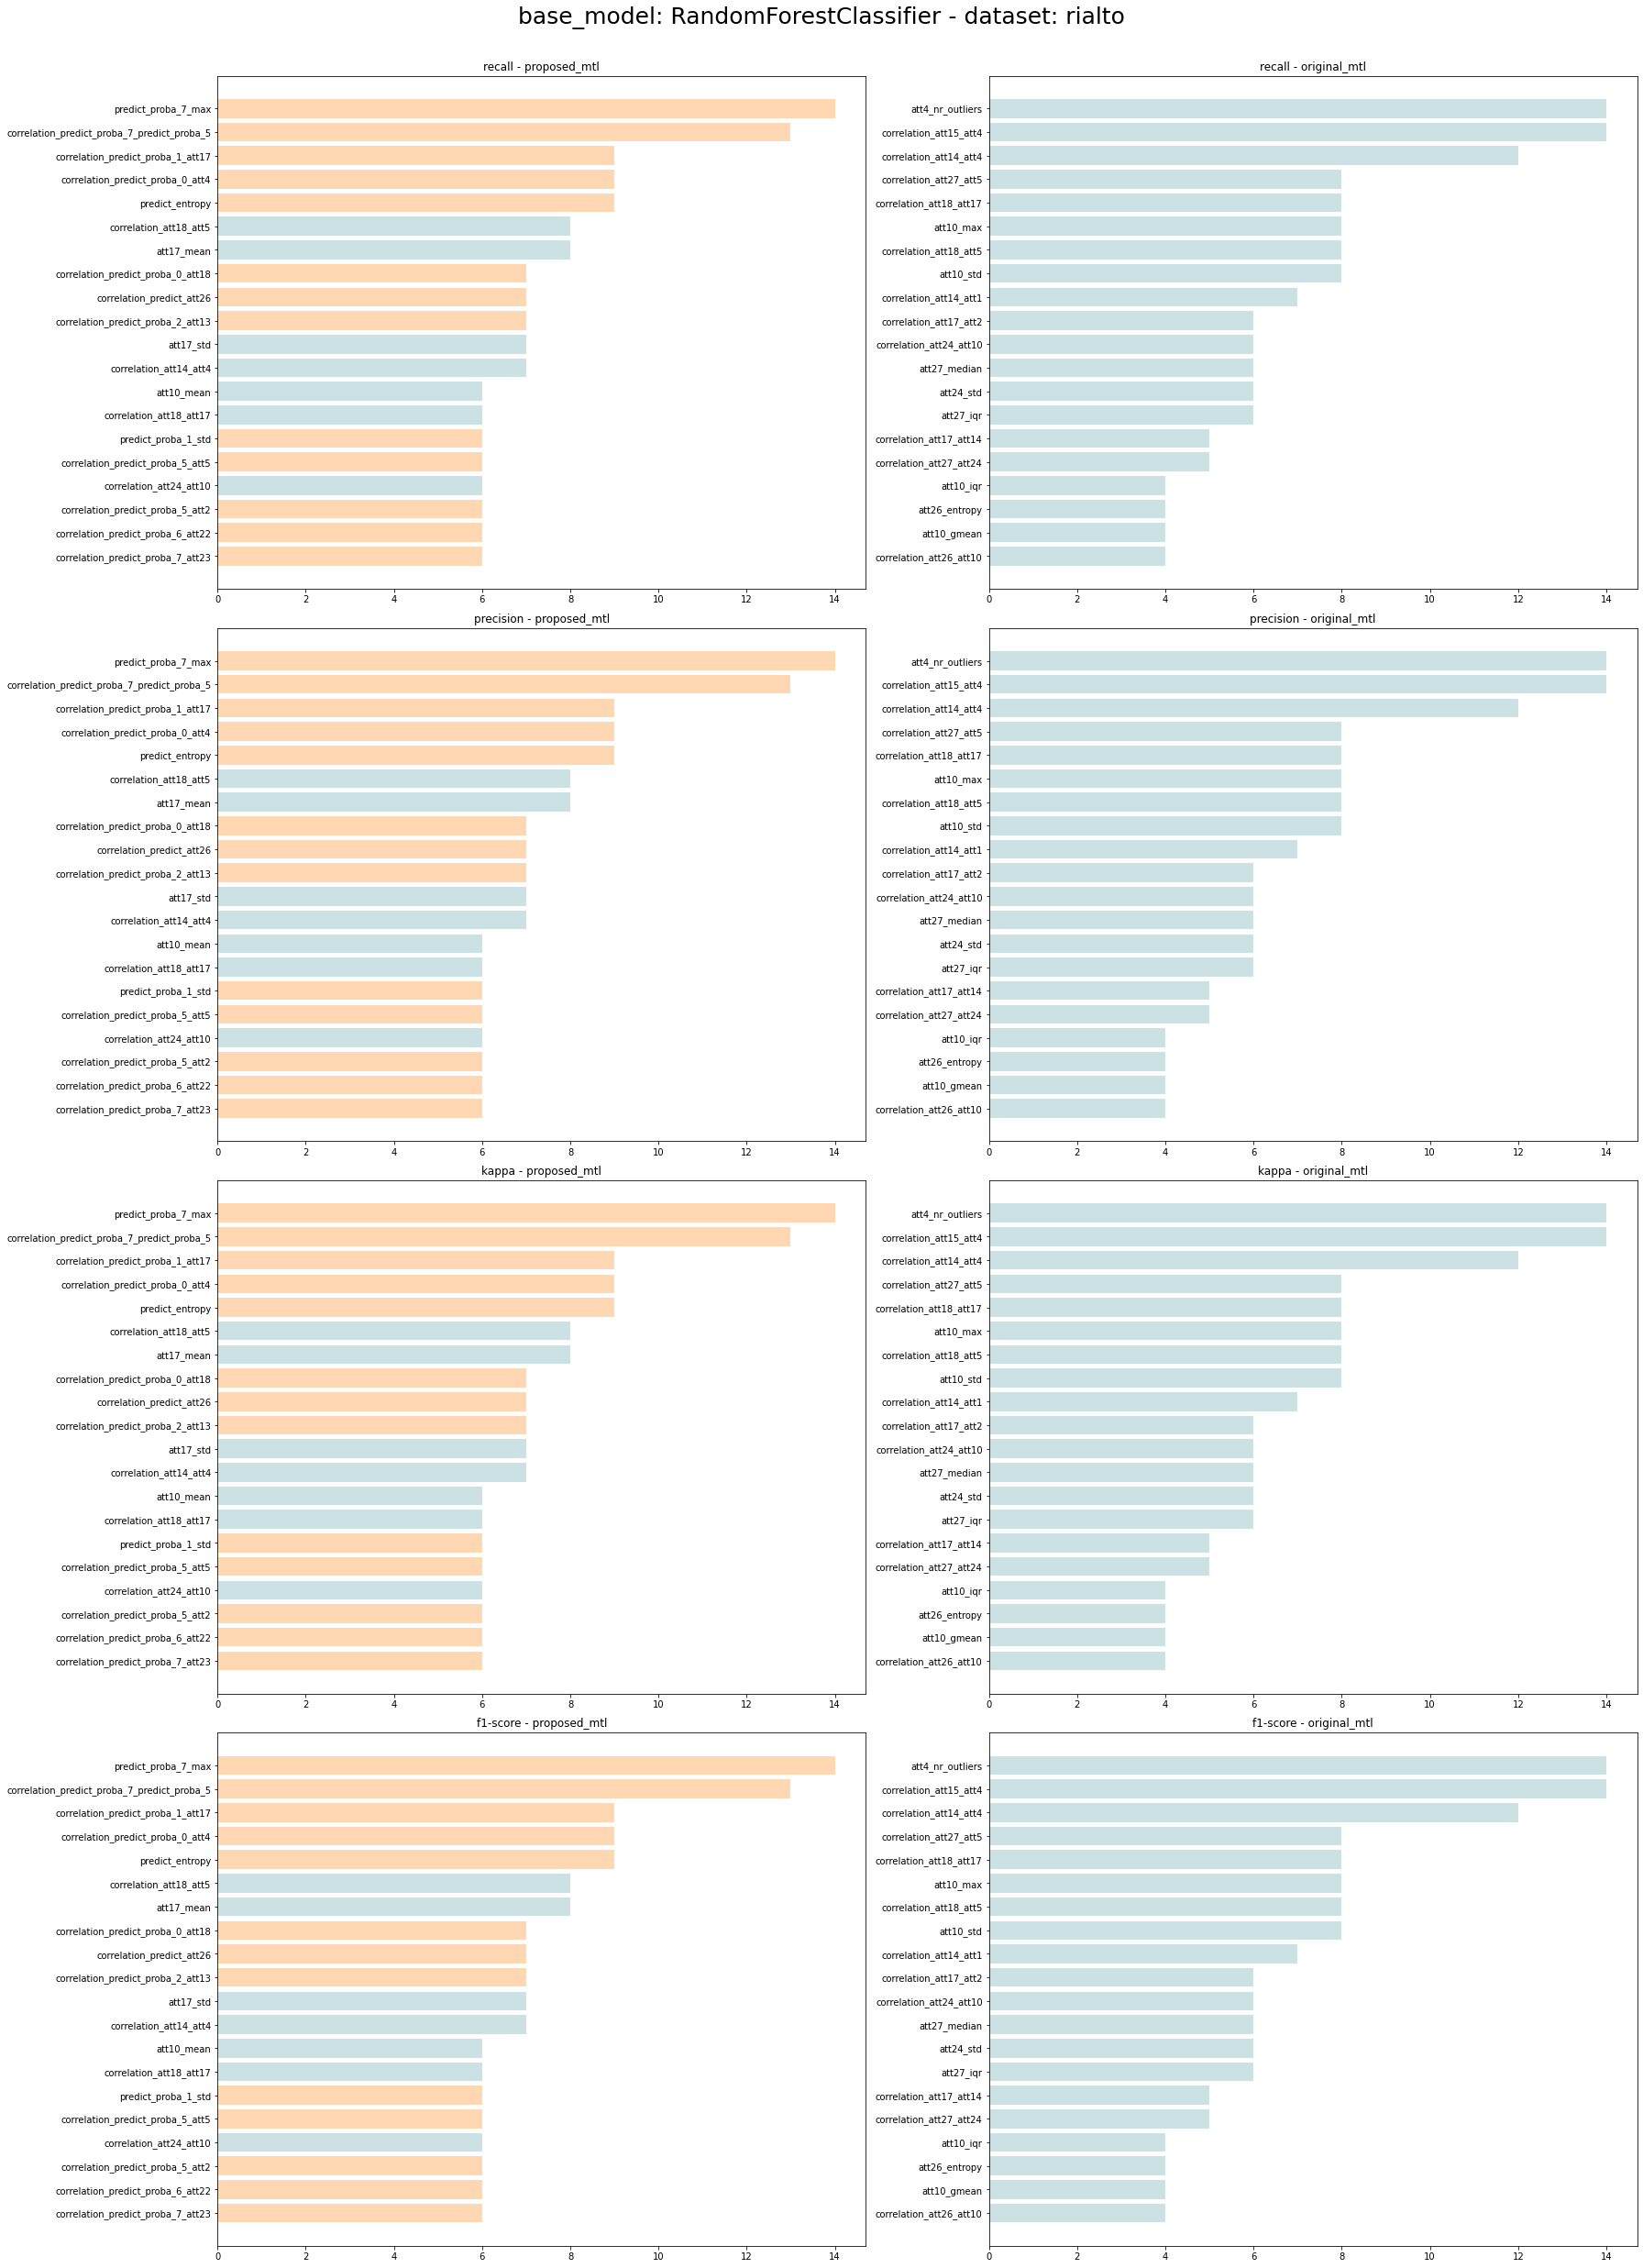

In [11]:
run(base_model="RandomForestClassifier", dataset="rialto", feature_fraction=FINAL_FEATURE_FRACTION["rialto"])

# Find most important features on average

In [37]:
DRIFT_METRICS_DICT = {
    "psi_": "PsiCalculator",
    "overlap_": "OmvPht",
    "omv_pth": "OmvPht",
    "dc_accuracy": "DomainClassifier",
    "dc_drift_flag": "DomainClassifier",
    "_ks_statistic": "SqsiCalculator",
    "_ks_pvalue": "SqsiCalculator",
    "sqsi_drift_flag": "SqsiCalculator",
    "distance_class_": "Udetector",
    "u_detect_drift_flag": "Udetector",
    "compacness": "ClusteringMetrics",
    "kmeans_n_iter": "ClusteringMetrics",
    "kmeans_n_clusters": "ClusteringMetrics",
    "kmeans_inertia": "ClusteringMetrics",
    "predict": "ScoringMetrics",
    "last": "ScoringMetrics",
    "_uniqueness_ratio": "MiscellaneousMetrics",
    "prop_pca": "MiscellaneousMetrics",
    "_sparsity": "MiscellaneousMetrics",
}

BASE_MODELS = [
    "RandomForestClassifier",
    "SVC",
    "LogisticRegression",
    "DecisionTreeClassifier"
]

COLORS = [
    "#ffd7b3", # orange
    "#cce1e4", # green
    "#d9d9d9", # grey
    "#6aa4c8ff", # blue
    "#E08637", # dark orange
    "#F5E3AD", # yellow
    "#5B919A", # dark green
    ]

DATASETS = list(FINAL_FEATURE_FRACTION.keys())

def get_mfe_type(row):
    for key, value in DRIFT_METRICS_DICT.items():
        if key in row["feature"]:
            return value
    return "StatsMetrics"

def get_imps(base_model: str="RandomForestClassifier", dataset: str="electricity", feature_fraction: int=100, normalize: bool=True, select_top_n: int=None):
    data = _load_data(base_model, dataset, feature_fraction)
    data.pop("auc", None)
    imp_df = _get_mean_importances(data)
    imp_df["base_model"] = base_model
    imp_df["dataset"] = dataset
    imp_df["mfe_type"] = imp_df.apply(get_mfe_type, axis=1)
    if normalize:
        imp_df["importance"] = (imp_df["importance"]-imp_df["importance"].min())/(imp_df["importance"].max()-imp_df["importance"].min())
    if select_top_n:
        imp_df = imp_df.sort_values(by=["importance"]).tail(select_top_n)
    return imp_df

def plot_bars(importances):
    grouped_imps = importances[["mfe_type", "importance"]].groupby("mfe_type").sum()
    df_plot = grouped_imps["importance"].sort_index()
    ax = df_plot.plot.barh(figsize=(10,6), fontsize=16, color=COLORS[1])
    total = df_plot.sum()

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{100*width/total: .1f}%', (x + width * 1.05, y + height/2), ha='center', fontsize=14)

## Considering all cases

In [13]:
all_imps = pd.DataFrame()
for base_model in BASE_MODELS:
    for dataset in DATASETS:
        this_df = get_imps(base_model=base_model, dataset=dataset, feature_fraction=FINAL_FEATURE_FRACTION[dataset])
        all_imps = pd.concat([all_imps, this_df], ignore_index=True)
all_imps[["mfe_type", "importance"]].groupby("mfe_type").sum()

,importance
mfe_type,
ClusteringMetrics,53.073033
DomainClassifier,2.377407
MiscellaneousMetrics,38.164248
OmvPht,40.565176
PsiCalculator,45.375948
ScoringMetrics,362.147835
SqsiCalculator,14.399668
StatsMetrics,976.470243
Udetector,23.200413


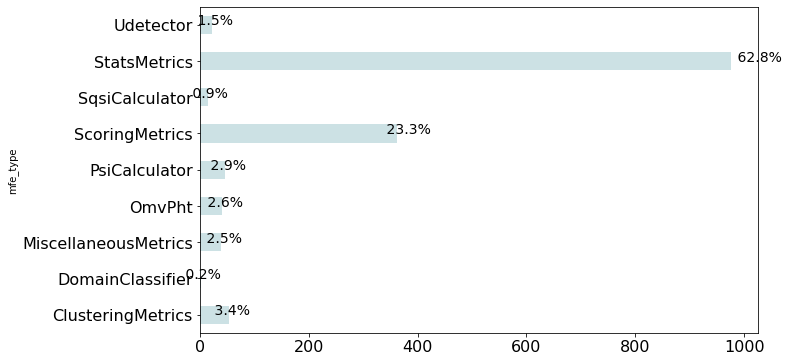

In [38]:
plot_bars(all_imps)

## Considering top n cases

In [15]:
top_n_imps = pd.DataFrame()
for base_model in BASE_MODELS:
    for dataset in DATASETS:
        this_df = get_imps(base_model=base_model, dataset=dataset, feature_fraction=FINAL_FEATURE_FRACTION[dataset], select_top_n=50)
        top_n_imps = pd.concat([top_n_imps, this_df], ignore_index=True)
top_n_imps[["mfe_type", "importance"]].groupby("mfe_type").sum()

,importance
mfe_type,
ClusteringMetrics,23.445628
MiscellaneousMetrics,2.481403
OmvPht,14.421318
PsiCalculator,14.262959
ScoringMetrics,90.701736
SqsiCalculator,2.121101
StatsMetrics,306.641825
Udetector,8.776873


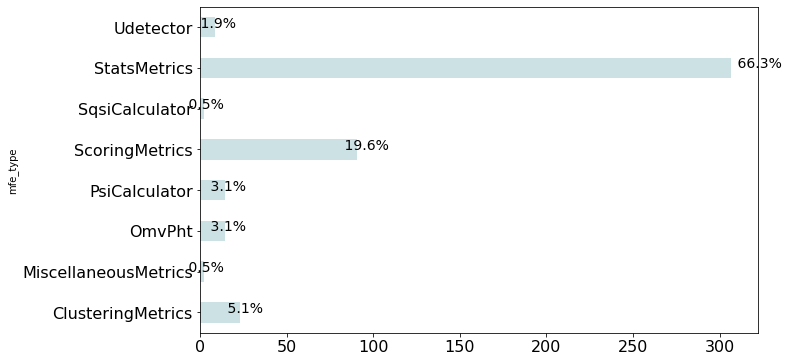

In [39]:
plot_bars(top_n_imps)

## Considering only cases in which the proposed MtL was better than the original

In [16]:
GOOD_CASES = [
    {"dataset": "electricity", "base_models": BASE_MODELS, "meta_label": "kappa"},
    {"dataset": "electricity", "base_models": ["RandomForestClassifier", "SVC", "DecisionTreeClassifier"], "meta_label": "recall"},
    {"dataset": "rialto", "base_models": ["RandomForestClassifier", "LogisticRegression", "DecisionTreeClassifier"], "meta_label": None},
    {"dataset": "powersupply", "base_models": ["SVC", "LogisticRegression"], "meta_label": None},
    {"dataset": "airlines", "base_models": ["RandomForestClassifier", "LogisticRegression"], "meta_label": "kappa"},
]

good_cases_imps = pd.DataFrame()
for case in GOOD_CASES:
    for base_model in case["base_models"]:
        this_df = get_imps(base_model=base_model, dataset=case["dataset"], feature_fraction=FINAL_FEATURE_FRACTION[case["dataset"]])
        if case["meta_label"]:
            this_df[this_df["meta_label"] == case["meta_label"]]
        good_cases_imps = pd.concat([good_cases_imps, this_df], ignore_index=True)
good_cases_imps[["mfe_type", "importance"]].groupby("mfe_type").sum()

,importance
mfe_type,
ClusteringMetrics,40.630725
DomainClassifier,1.267559
MiscellaneousMetrics,26.674393
OmvPht,24.542388
PsiCalculator,41.925013
ScoringMetrics,264.806905
SqsiCalculator,13.621153
StatsMetrics,791.242164
Udetector,17.509083


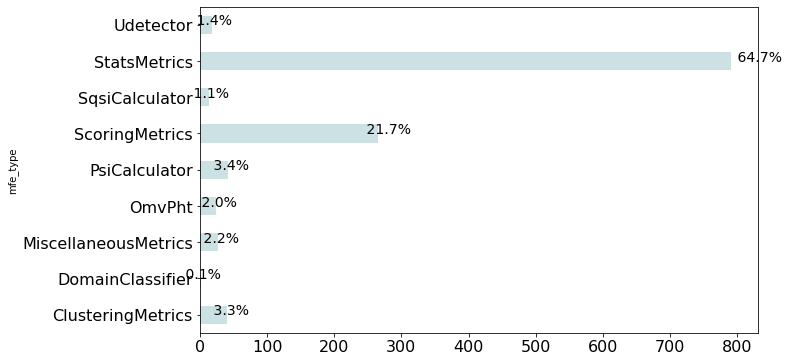

In [41]:
plot_bars(good_cases_imps)